In [1]:
import pandas as pd
import numpy as np
import itertools
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from operator import itemgetter

In [20]:
x_train = pd.read_csv('X_train.csv')
y_train = pd.read_csv('y_train.csv')
y_train = y_train['Genre']
x_train.drop(columns = ['Unnamed: 0', 'track_id'], inplace=True)
x_test = pd.read_csv('X_test.csv')
y_test = pd.read_csv('y_test.csv')
y_test = y_test['Genre']
x_test.drop(columns = ['Unnamed: 0', 'track_id'], inplace=True)

In [3]:
y_train.value_counts()

Rock          6614
Pop           1204
Metal         1048
Country        852
Rap            779
RnB            646
Electronic     487
Punk           385
Reggae         312
Folk           291
Jazz           269
Latin          202
Blues          195
Name: Genre, dtype: int64

In [4]:
x_train.shape

(13284, 41)

## Random Forest 

Now to implement a Random Forest model. We don't know the best value for the number of values to take at each split so we will first use cross validation

In [5]:
rf = RandomForestClassifier(n_estimators= 100)
params = {'max_features':range(2, 35, 1)}
gsrf = GridSearchCV(estimator=rf,
                  param_grid=params,
                  n_jobs=1,
                  cv=5,
                  verbose=1)
gsrf.fit(x_train, y_train)

Fitting 5 folds for each of 33 candidates, totalling 165 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 165 out of 165 | elapsed: 43.3min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=1,
       param_grid={'max_features': range(2, 35)}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring=None, verbose=1)

In [9]:
dir(gsrf)
print(gsrf.best_score_)
rf = gsrf.best_estimator_
gsrf.best_estimator_

0.590183679614574


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=27, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

This cross validation indicates 23 as the optimal number of variables. Now that we have our ideal number of variables at each selection point we can set up a model and test

In [10]:
rf.fit(x_train, y_train)
predictions = rf.predict(x_test)

In [21]:
predictions = rf.predict(x_test)
z = (y_test == predictions).sum()
z/len(y_test)

0.5809372877518678

In [22]:
pd.Series(predictions).value_counts()

Rock          3393
Rap            293
Metal          227
Pop            171
Country         88
RnB             81
Electronic      50
Punk            43
Jazz            27
Reggae          21
Blues           13
Latin            6
Folk             4
dtype: int64

In [23]:
y_test.value_counts()

Rock          2148
Pop            411
Metal          345
Country        273
Rap            251
RnB            218
Electronic     180
Folk           120
Punk           119
Reggae         100
Latin           97
Jazz            87
Blues           68
Name: Genre, dtype: int64

Now we will explore the multiclass confusion matrix

In [24]:
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import seaborn as sns
d = list(set(y_test.values))
conf = confusion_matrix(y_test, predictions, labels = d)
normed_matrix = normalize(conf, axis=1, norm='l1')

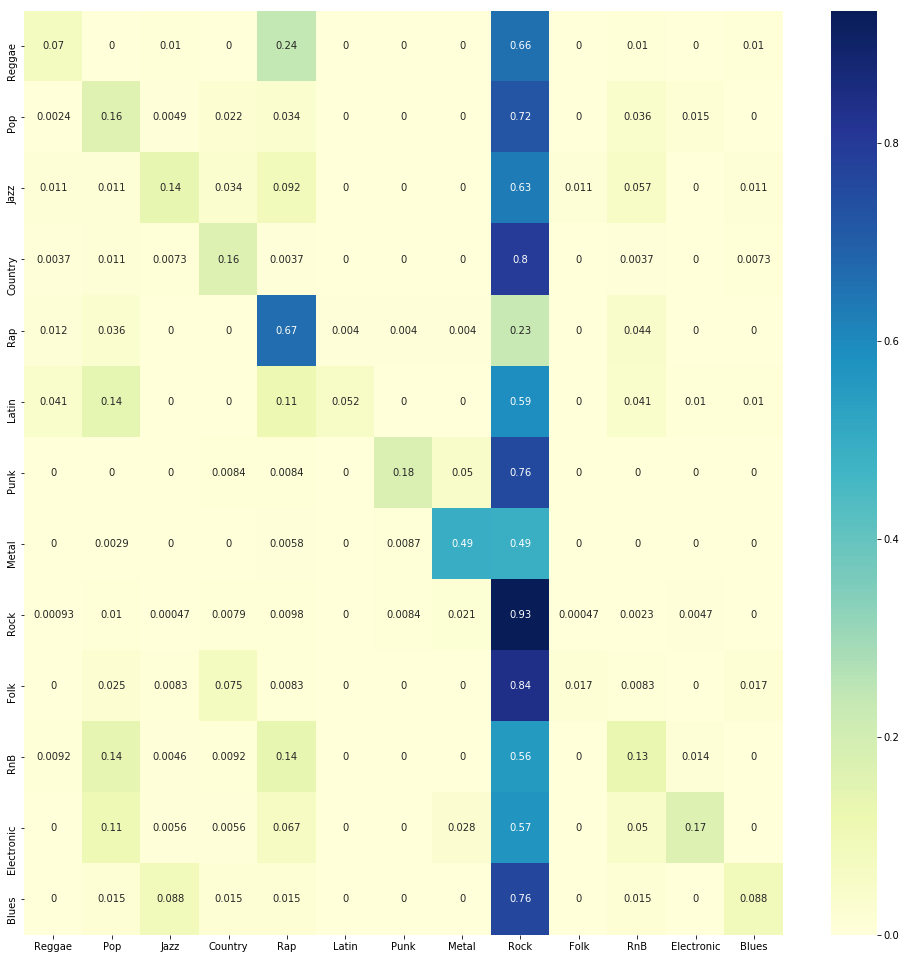

In [25]:
fig, ax = plt.subplots(figsize=(17,17))
sns.heatmap(normed_matrix, cmap="YlGnBu", ax = ax, xticklabels = d, yticklabels = d, annot = True)

While the results of this test performed okay, they are not very sensitive to less common genres with several lesser genres not appearing much

## Boosting

Now boosting can also be implemented. For this we will implement gradient boosting classification. First a learning rate needs to be chosen. Additionally, a max tree depth needs to be found.

In [6]:
gb = GradientBoostingClassifier(n_estimators=30, max_features=20, random_state = 0)
params = {'learning_rate':[0.05, 0.1, 0.25, 0.5, 0.75, 1], 'max_depth':[2, 3, 4, 5]}
gsgb = GridSearchCV(estimator=gb,
                  param_grid=params,
                  n_jobs=1,
                  cv=5,
                  verbose=1)
gsgb.fit(x_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed: 15.7min finished
C:\Users\justi\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=20, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples...      subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=1,
       param_grid={'learning_rate': [0.05, 0.1, 0.25, 0.5, 0.75, 1], 'max_depth': [2, 3, 4, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [32]:
dir(gsgb)
print(gsgb.best_score_)
gsgb.best_estimator_

0.5886781090033123


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=5,
              max_features=20, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=30,
              n_iter_no_change=None, presort='auto', random_state=0,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [33]:
gb = GradientBoostingClassifier(n_estimators=300, max_features=20, random_state = 0, learning_rate = 0.1, max_depth = 5)
gb.fit(x_train, y_train)
predictions = gb.predict(x_test)
predictions

array(['Rock', 'Metal', 'Rock', ..., 'Rock', 'Rock', 'Pop'], dtype=object)

In [34]:
z = (y_test == predictions).sum()
z/len(y_test)

0.5904460040751641

Comparing the distributions of the actual and predicted values

In [35]:
y_test.value_counts()

Rock          2148
Pop            411
Metal          345
Country        273
Rap            251
RnB            218
Electronic     180
Folk           120
Punk           119
Reggae         100
Latin           97
Jazz            87
Blues           68
Name: Genre, dtype: int64

In [36]:
pd.Series(predictions).value_counts()

Rock          3089
Pop            272
Metal          263
Rap            245
Country        168
RnB            122
Electronic      81
Punk            51
Reggae          40
Folk            29
Jazz            27
Blues           18
Latin           12
dtype: int64

Exploring the confusion matrix

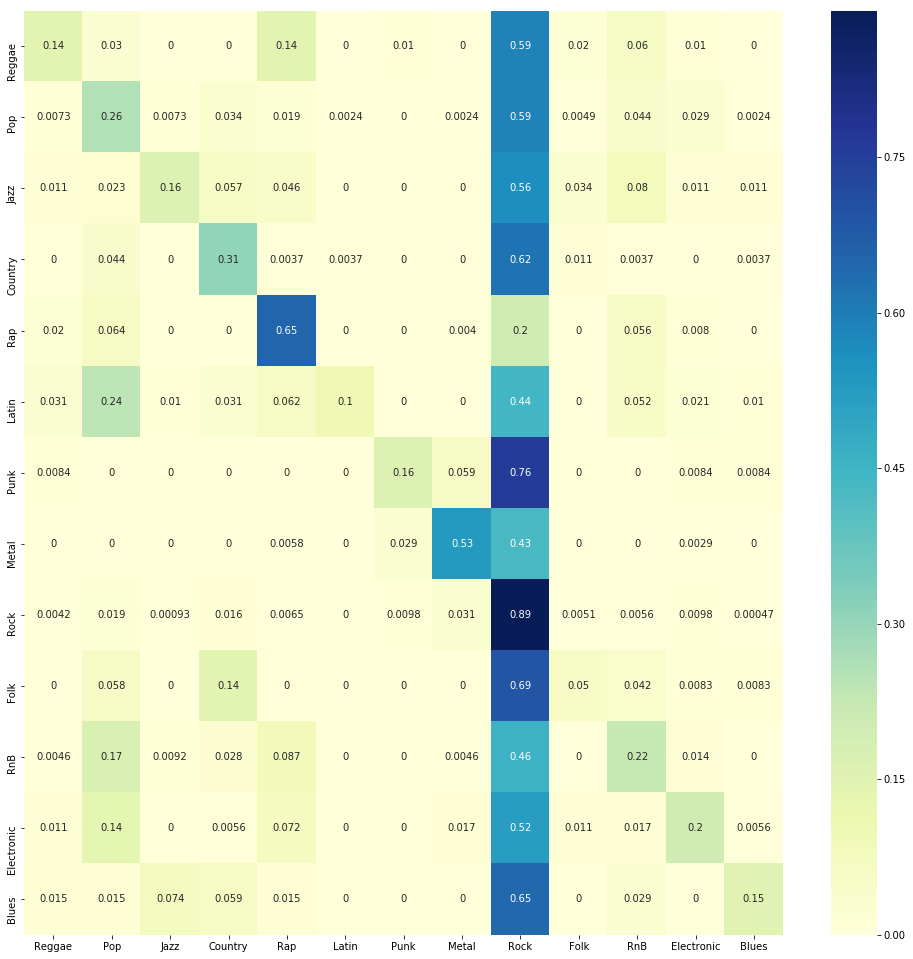

In [37]:
conf = confusion_matrix(y_test, predictions, labels = d)
normed_matrix = normalize(conf, axis=1, norm='l1')
fig, ax = plt.subplots(figsize=(17,17))
sns.heatmap(normed_matrix, cmap="YlGnBu", ax = ax, xticklabels = d, yticklabels = d, annot = True)

While the total accuracy here is slightly less than random forest, it was able to at able to cover lesser genres better

## MLP Classifier

Now for something more sophisticated. Next we can try to implement a shallow neural net intended for the classification of varying data. 

In [7]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(random_state = 9)
params = {'hidden_layer_sizes':[50,100,150,200], 'alpha':[.0001, .001, .01, .05], 'activation': ['logistic', 'relu', 'tanh']}
gsmp = GridSearchCV(estimator=mlp,
                  param_grid=params,
                  n_jobs=1,
                  cv=5,
                  verbose=1)
gsmp.fit(x_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed: 19.7min finished
C:\Users\justi\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=9, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False),
       fit_params=None, iid='warn', n_jobs=1,
       param_grid={'hidden_layer_sizes': [50, 100, 150, 200], 'alpha': [0.0001, 0.001, 0.01, 0.05], 'activation': ['logistic', 'relu', 'tanh']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [17]:
dir(gsmp)
print(gsmp.best_score_)
mlp = gsmp.best_estimator_
gsmp.best_estimator_

0.5313911472448057


MLPClassifier(activation='logistic', alpha=0.001, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=100, learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=9, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [38]:
mlp.fit(x_train, y_train)
predictions = mlp.predict(x_test)
predictions

array(['Rock', 'Rock', 'Rock', ..., 'Rock', 'Rock', 'Rap'], dtype='<U10')

In [39]:
z = (y_test == predictions).sum()
z/len(y_test)

0.5277337559429477

In [40]:
pd.Series(predictions).value_counts()

Rock          3471
Rap            387
RnB            158
Metal          124
Pop            113
Jazz            74
Electronic      57
Country         25
Punk             4
Reggae           2
Folk             2
dtype: int64

Exploring the confusion matrix

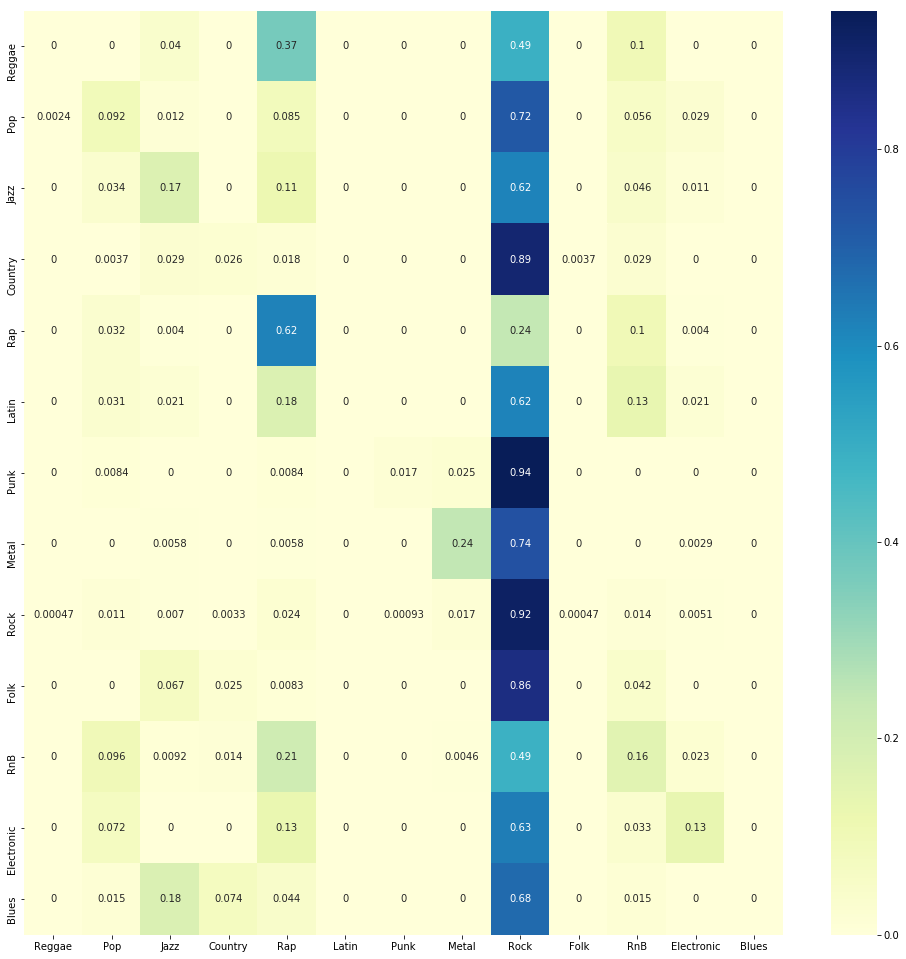

In [41]:
conf = confusion_matrix(y_test, predictions, labels = d)
normed_matrix = normalize(conf, axis=1, norm='l1')
fig, ax = plt.subplots(figsize=(17,17))
sns.heatmap(normed_matrix, cmap="YlGnBu", ax = ax, xticklabels = d, yticklabels = d, annot = True)

The results here are quite similar to the other two methods except that a few of the less common methods are never even identified

## K-Nearest Neighbors

First it is necessary to determine the optimal number of nearest neighbors

In [8]:
from sklearn.neighbors import KNeighborsClassifier
vals = []
neighbs = [2,3,4,5,6,7,8,9,10]+(list(range(10,105,5)))
for i in neighbs:
    neigh = KNeighborsClassifier(n_neighbors=i)
    neigh.fit(x_train, y_train) 
    cv = cross_val_score(neigh, x_train, y_train, cv=5)
    vals.append((i,sum(cv)/5))

In [18]:
print(max(vals,key=itemgetter(1))[0]) 
fin = max(vals,key=itemgetter(1))[0]
vals

50


[(2, 0.24428182456487738),
 (3, 0.3441793959246263),
 (4, 0.39227808829152067),
 (5, 0.4177262396328561),
 (6, 0.4347382252001144),
 (7, 0.446473600816658),
 (8, 0.45686416474315517),
 (9, 0.46349318276937607),
 (10, 0.4716217630438968),
 (10, 0.4716217630438968),
 (15, 0.4922463387298615),
 (20, 0.49706432370674863),
 (25, 0.49631235858293865),
 (30, 0.49774325401705977),
 (35, 0.4977431407821653),
 (40, 0.49804372319236057),
 (45, 0.4979685352224357),
 (50, 0.49804397845140586),
 (55, 0.4978930919934655),
 (60, 0.4978930919934655),
 (65, 0.4978930919934655),
 (70, 0.4978930919934655),
 (75, 0.4978930919934655),
 (80, 0.4978930919934655),
 (85, 0.4978930919934655),
 (90, 0.4978930919934655),
 (95, 0.4978930919934655),
 (100, 0.4978930919934655)]

In [45]:
neigh = KNeighborsClassifier(n_neighbors=fin)
neigh.fit(x_train, y_train)
predictions = neigh.predict(x_test)

In [46]:
print(pd.Series(predictions).nunique())
z = (y_test == predictions).sum()
z/len(y_test)

4


0.48675571654969435

In [44]:
pd.Series(predictions).value_counts()

Rock    4416
Pop        1
dtype: int64

Exploring the confusion matrix

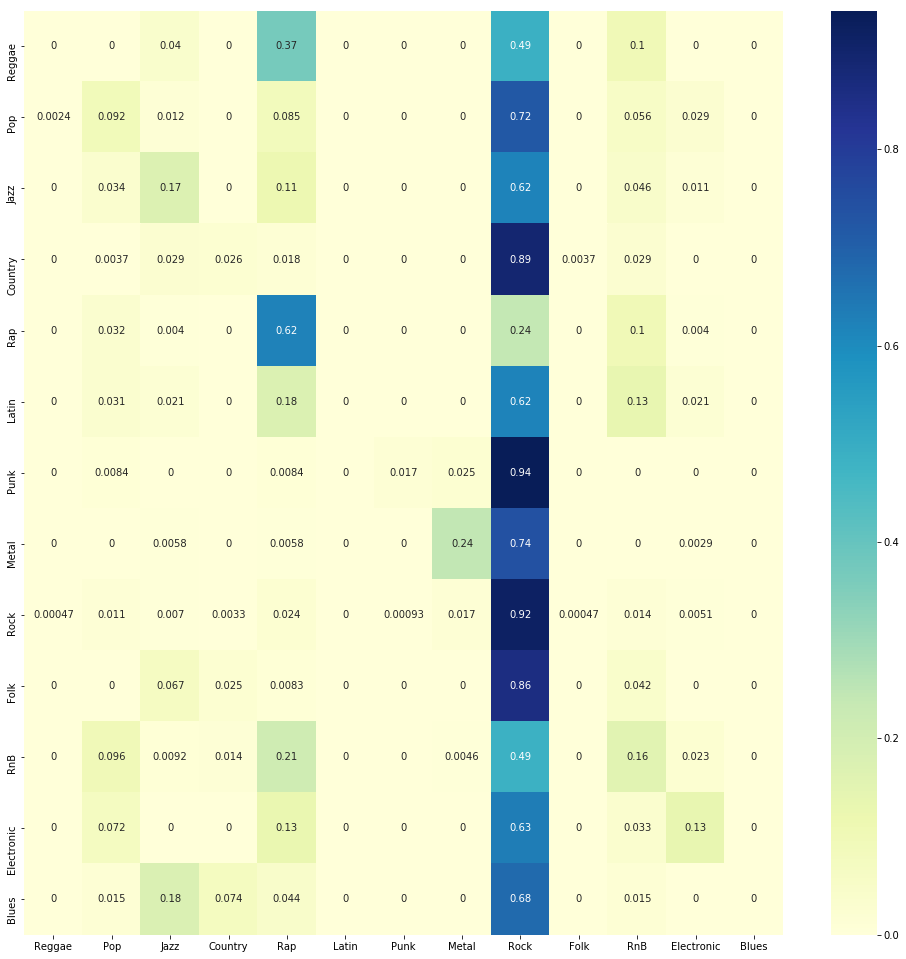

In [47]:
fig, ax = plt.subplots(figsize=(17,17))
sns.heatmap(normed_matrix, cmap="YlGnBu", ax = ax, xticklabels = d, yticklabels = d, annot = True)

The results here are severly poor compared to the other two methods with rock being the only category picked up

## Oversampling

Attempting to oversample to make up for data skew. We will now try to randomly oversample the deficient columns to attempt to better model the less notable results. We will not include the rows containing Rock in this process because there would be an obscene amount of resampling for many of the values which would essentially require them to completely repeat the entire number of rows repeatedly

In [48]:
from imblearn.over_sampling import RandomOverSampler, ADASYN
x_train['y'] = y_train
x1 = x_train.loc[x_train['y'] == 'Rock']
x2 = x_train.loc[x_train['y'] != 'Rock']
y = x2['y']
x2.drop(columns = ['y'], inplace = True)
b = list(x2.columns.values)
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(x2, y)
X_resampled = pd.DataFrame(X_resampled, columns = b)
y_resampled = pd.Series(y_resampled)
X_resampled['y'] = y_resampled
x_fin = pd.concat([x1, X_resampled])
y_train2 = x_fin['y']
x_train2 = x_fin.drop(columns = ['y'])

C:\Users\justi\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [49]:
x_train2.shape

(21062, 41)

In [50]:
y_train2.shape

(21062,)

In [51]:
y_train2.value_counts()

Rock          6614
Punk          1204
RnB           1204
Country       1204
Blues         1204
Latin         1204
Reggae        1204
Metal         1204
Electronic    1204
Rap           1204
Folk          1204
Jazz          1204
Pop           1204
Name: y, dtype: int64

In [52]:
rf.fit(x_train2, y_train2)
predictions = rf.predict(x_test)
z = (y_test == predictions).sum()
z/len(y_test)

0.5798052977133801

In [53]:
neigh.fit(x_train2, y_train2)
predictions = neigh.predict(x_test)
print(pd.Series(predictions).nunique())
z = (y_test == predictions).sum()
z/len(y_test)

13


0.4204211002943174

In [54]:
gb.fit(x_train2, y_train2)
predictions = gb.predict(x_test)
z = (y_test == predictions).sum()
z/len(y_test)

0.5967851482906951

In [55]:
mlp.fit(x_train2, y_train2)
predictions = mlp.predict(x_test)
z = (y_test == predictions).sum()
z/len(y_test)

0.47271904007244736

The only value that actually seemed to benefit from this over sampling technique was the random forest and even that was only slightly. Every other method lost accuracy in some way